<a href="https://colab.research.google.com/github/varun-beep/NLP_LAB/blob/main/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout

In [75]:
#datasets
train_path = "/content/train.csv"
test_path = "/content/test.csv"
training_full_path = "/content/training.1600000.processed.noemoticon.csv"

train_df = pd.read_csv(train_path, encoding="ISO-8859-1")
test_df = pd.read_csv(test_path, encoding="ISO-8859-1")
full_df = pd.read_csv(training_full_path, encoding="ISO-8859-1", names=["polarity", "id", "date", "query", "user", "text"], usecols=[0, 5])

<ipython-input-75-e267864c299f>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(training_full_path, encoding="ISO-8859-1", names=["polarity", "id", "date", "query", "user", "text"], usecols=[0, 5])


In [76]:
#(0 = Negative, 4 = Positive)
full_df["polarity"] = full_df["polarity"].replace({0: "negative", 4: "positive"})
train_df = train_df.rename(columns={"sentiment": "polarity"})

# Combine datasets and sample
df = pd.concat([train_df[["text", "polarity"]], full_df], ignore_index=True)
df = df.sample(100000, random_state=42)  # Use a smaller subset for efficiency

In [77]:
# Text Cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[@#]\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    return " ".join(tokens)

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
df["clean_text"] = df["text"].astype(str).apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [78]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df["clean_text"])
sequences = tokenizer.texts_to_sequences(df["clean_text"])
padded_sequences = pad_sequences(sequences, maxlen=50)

In [79]:
# Encode labels
df["polarity"] = df["polarity"].map({"negative": 0, "positive": 1})

# Split Data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df["polarity"], test_size=0.2, random_state=42)

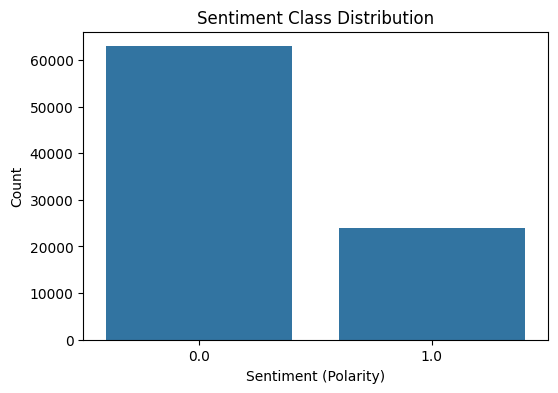

In [80]:
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['polarity'])  # Change 'sentiment' to 'polarity'
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment (Polarity)")
plt.ylabel("Count")
plt.show()

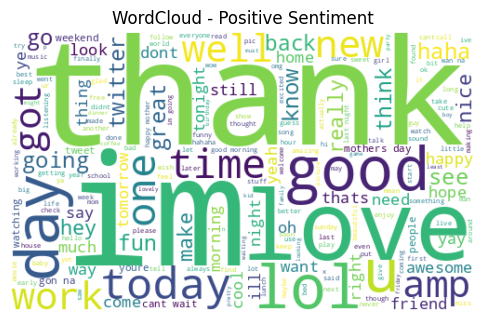

In [81]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df['polarity'] = pd.to_numeric(df['polarity'], errors='coerce')  # Convert to numeric, forcing invalid values to NaN
df['polarity'] = df['polarity'].fillna(0).astype(int)  # Replace NaNs with 0 (neutral/negative) and convert

# Extract positive sentiment text
positive_text = " ".join(df[df['polarity'] == 1]['clean_text'])

# Generate WordCloud
plt.figure(figsize=(6, 4))
wordcloud_pos = WordCloud(width=500, height=300, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Positive Sentiment")
plt.show()


In [82]:
# Model Function
def create_model(model_type="RNN"):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
    if model_type == "RNN":
        model.add(SimpleRNN(64, return_sequences=False))
    else:
        model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [83]:
# Model Function
def create_model(model_type="RNN"):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
    if model_type == "RNN":
        model.add(SimpleRNN(64, return_sequences=False))
    else:
        model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [84]:
import numpy as np
# Remove NaN values from y_train and y_test
X_train = X_train[~np.isnan(y_train)]
y_train = y_train[~np.isnan(y_train)]

X_test = X_test[~np.isnan(y_test)]
y_test = y_test[~np.isnan(y_test)]

In [85]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

In [86]:
import tensorflow as tf

# Define an optimizer with gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

# Compile your RNN model
rnn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Train and Evaluate RNN
rnn_model = create_model("RNN")
rnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
y_pred_rnn = (rnn_model.predict(X_test) > 0.5).astype(int)
print("RNN Model Performance:\n", classification_report(y_test, y_pred_rnn))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1086/1086 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7663 - loss: 0.5011 - val_accuracy: 0.8065 - val_loss: 0.4268
Epoch 2/5
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8409 - loss: 0.3685 - val_accuracy: 0.7989 - val_loss: 0.4399
Epoch 3/5
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8867 - loss: 0.2790 - val_accuracy: 0.7905 - val_loss: 0.4938
Epoch 4/5
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8997 - loss: 0.2485 - val_accuracy: 0.7714 - val_loss: 0.5532
Epoch 5/5
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9215 - loss: 0.2010 - val_accuracy: 0.7673 - val_loss: 0.6163
541/541 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step
RNN Model Performance:
               precision    recall  f1-score   support

         0.0       0.83      0.85      0.84     12480
         1.0       0.59      0.55      0.57      4826

    accuracy                           0.77     17306
   macro avg       0.71      0.70      0.71     17306
weighted avg       0.76

In [ ]:
# Train and Evaluate LSTM
lstm_model = create_model("LSTM")
lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
y_pred_lstm = (lstm_model.predict(X_test) > 0.5).astype(int)
print("LSTM Model Performance:\n", classification_report(y_test, y_pred_lstm))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1086/1086 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7665 - loss: 0.4936 - val_accuracy: 0.8097 - val_loss: 0.4144
Epoch 2/5
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8389 - loss: 0.3661 - val_accuracy: 0.8121 - val_loss: 0.4178
Epoch 3/5
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8552 - loss: 0.3248 - val_accuracy: 0.8102 - val_loss: 0.4407
Epoch 4/5
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8769 - loss: 0.2801 - val_accuracy: 0.8041 - val_loss: 0.4852
Epoch 5/5
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8932 - loss: 0.2451 - val_accuracy: 0.7902 - val_loss: 0.5481
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
LSTM Model Performance:
               precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     12480
         1.0       0.63      0.59      0.61      4826

    accuracy                           0.79     17306
   macro avg       0.74      0.73      0.73     17306
weighted avg       0.7

In [87]:
from sklearn.model_selection import train_test_split

# Ensure validation data exists
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [89]:
# Retrain RNN model
history_rnn = rnn_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
history_rnn = history_rnn.history  # Save history

# Retrain LSTM model
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
history_lstm = history_lstm.history

Epoch 1/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9669 - loss: 0.0868 - val_accuracy: 0.7709 - val_loss: 0.8211
Epoch 2/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9705 - loss: 0.0778 - val_accuracy: 0.7650 - val_loss: 0.8443
Epoch 3/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9729 - loss: 0.0702 - val_accuracy: 0.7755 - val_loss: 0.8250
Epoch 4/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9746 - loss: 0.0676 - val_accuracy: 0.7688 - val_loss: 0.9137
Epoch 5/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9746 - loss: 0.0640 - val_accuracy: 0.7749 - val_loss: 0.8994
Epoch 1/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9704 - loss: 0.0700 - val_accuracy: 0.8120 - val_loss: 0.9728
Epoch 2/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9731 - loss: 0.0651 - val_accuracy: 0.8068 - val_loss: 1.0090
Epoch 3/5
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9734 - loss: 0.0635 -

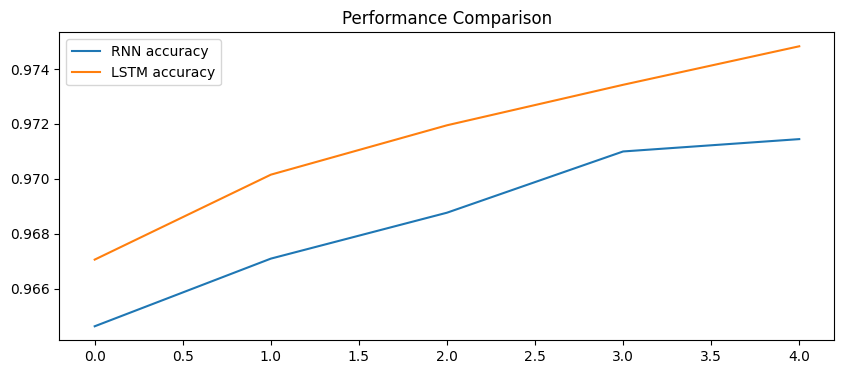

In [90]:
# Visualization of Performance
metrics = ["accuracy"]
history_rnn = rnn_model.history.history
history_lstm = lstm_model.history.history

plt.figure(figsize=(10, 4))
for metric in metrics:
    plt.plot(history_rnn[metric], label=f"RNN {metric}")
    plt.plot(history_lstm[metric], label=f"LSTM {metric}")
plt.legend()
plt.title("Performance Comparison")
plt.show()

In [92]:
# Custom Sentiment Prediction with User Input
def predict_sentiment(model, tokenizer, text):
    seq = tokenizer.texts_to_sequences([clean_text(text)])
    padded = pad_sequences(seq, maxlen=50)
    prediction = model.predict(padded)
    return "Positive" if prediction > 0.5 else "Negative"
# Taking user input
user_text = input("Enter a sentence for sentiment analysis: ")

# Predict sentiment for user input
print("RNN Prediction:", predict_sentiment(rnn_model, tokenizer, user_text))
print("LSTM Prediction:", predict_sentiment(lstm_model, tokenizer, user_text))

Enter a sentence for sentiment analysis: I love going to Christ University
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
RNN Prediction: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
LSTM Prediction: Negative


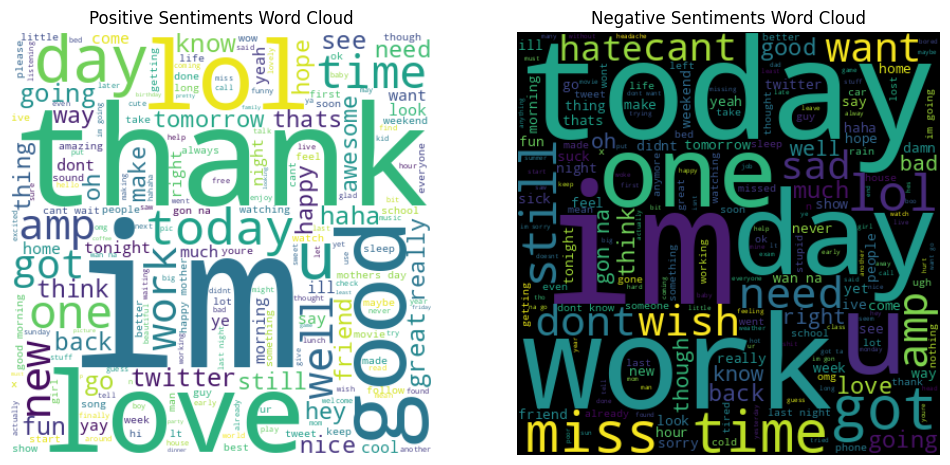

In [93]:
# Word Cloud Visualization
positive_text = " ".join(df[df["polarity"] == 1]["clean_text"])
negative_text = " ".join(df[df["polarity"] == 0]["clean_text"])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Positive Sentiments Word Cloud")
wordcloud_pos = WordCloud(width=400, height=400, background_color="white").generate(positive_text)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Negative Sentiments Word Cloud")
wordcloud_neg = WordCloud(width=400, height=400, background_color="black").generate(negative_text)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()